![arc-logo](admin/image/arc-logo.png)
# Projet P3
## HeadlinesRNNModel
Ce notebook retrace les différentes étapes de création d'un modèle de deep learning avec le jeu de données des titres d'articles financiers

`Auteur` : Romain Capocasale (INF3dlm-a)

`Superviseur` : Hatem Ghorbel

`Date` : 24.01.2020

# Importation

In [2]:
import numpy as np
import sys
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from matplotlib import pyplot as plt
np.random.seed(42)

# Récupération des données
Les phrases avec un sentiment compris entre -0.1 et 0.1 influence en mal la précision. En effet, si le système prédit un sentiment de 0.05 pour une phrase alors que son sentiment réel et de -0.05 la prédiction sera considéré come fausse. Alors qu'en réalité l'erreur commise est toute petite (0.10).
On voit que l'on perd 283 phrase a cause de ce processus.

In [3]:
dataset = pd.read_json('dataset/headlines_dataset/financialData.json')

In [4]:
print("size before : {}".format(len(dataset)))
dataset.drop(dataset[(dataset.sentiment >= -0.1) & (dataset.sentiment <= 0.1)].index, inplace=True)
print("size after : {}".format(len(dataset)))

size before : 2866
size after : 2583


# Prétrataitement 
j'utilise Gensim pour le prétraitement

In [5]:
pre_sentences = [' '.join(simple_preprocess(sentence)) for sentence in dataset['title'] ]

# Importation du word2vec financiers

In [6]:
sys.path.insert(0, 'word2vec/financialWord2vec/src')
from financial_corpus import FinancialCorpus
from financial_w2vec import FinancialWord2Vec

financial_w2vec = pickle.load(open('word2vec/financialWord2vec/data/models_pickle/FinancialWord2Vec.pkl','rb'))
w2vec_model = financial_w2vec.model
financial_corpus = financial_w2vec.financial_corpus

bigram_mod = financial_corpus.bigram_mod
trigram_mod = financial_corpus.bigram_mod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romain.capocasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sauvegarde du word2vec au format txt
Cette opération est effectué pour gagner en rapidité.

In [7]:
FINANCIAL_WORD2VEC_TXT_FILEPATH = "word2vec/financialWord2vec/financial_word2vec.txt"
w2vec_model.wv.save_word2vec_format(FINANCIAL_WORD2VEC_TXT_FILEPATH, binary=False)

# Récupération de la matrice de mot/vecteur
Le dictionnaire contient comme clé le mot et comme valeur le vecteur représantant ce mot.

In [8]:
embeddings_index = {}
f = open(FINANCIAL_WORD2VEC_TXT_FILEPATH, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

# Représentation de la phrase avec le padding

In [9]:
tokenizer_obj =  Tokenizer()
tokenizer_obj.fit_on_texts(pre_sentences)
sequences = tokenizer_obj.texts_to_sequences(pre_sentences)

word_index = tokenizer_obj.word_index
max_length = max([len(s.split()) for s in pre_sentences])
vocab_size = len(word_index) + 1

sentences_pad = pad_sequences(sequences, maxlen=max_length, padding='post')

# Création de la matrice index/vecteur
L'index de la case du tableau corresponds à l'index du mot. La valeur à cette index est le vecteur représantant le mot dans l'espace.

In [10]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    elif embedding_vector is None:
        embedding_matrix[i] = np.zeros(100)

# Création de l'architecture du réseau de neuronne
la matrice créé préceddment est passé en paramètre

In [11]:
model = Sequential()

model.add(Embedding(vocab_size, 100, input_length=max_length, embeddings_initializer=Constant(embedding_matrix)))
model.add(SimpleRNN(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 100)           376600    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                1872      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 378,489
Trainable params: 378,489
Non-trainable params: 0
_________________________________________________________________


# Récupération des observations et des étiquettes

In [12]:
y = np.array([1 if s >= 0 else 0 for s in dataset['sentiment']])
X_train_pad, X_test_pad, y_train, y_test = train_test_split(sentences_pad, y, test_size=0.2, random_state=42)

# Entrainement du modèle

In [13]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=20, verbose=2, validation_data=(X_test_pad, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2066 samples, validate on 517 samples
Epoch 1/20
 - 1s - loss: 0.6628 - accuracy: 0.6200 - val_loss: 0.6566 - val_accuracy: 0.6325
Epoch 2/20
 - 1s - loss: 0.6244 - accuracy: 0.6655 - val_loss: 0.6368 - val_accuracy: 0.6499
Epoch 3/20
 - 1s - loss: 0.5543 - accuracy: 0.7357 - val_loss: 0.6175 - val_accuracy: 0.6615
Epoch 4/20
 - 1s - loss: 0.4808 - accuracy: 0.7880 - val_loss: 0.6212 - val_accuracy: 0.6944
Epoch 5/20
 - 1s - loss: 0.4177 - accuracy: 0.8349 - val_loss: 0.6559 - val_accuracy: 0.6905
Epoch 6/20
 - 1s - loss: 0.3713 - accuracy: 0.8606 - val_loss: 0.6689 - val_accuracy: 0.7157
Epoch 7/20
 - 1s - loss: 0.3239 - accuracy: 0.8800 - val_loss: 0.7119 - val_accuracy: 0.6925
Epoch 8/20
 - 1s - loss: 0.2970 - accuracy: 0.8930 - val_loss: 0.7100 - val_accuracy: 0.7176
Epoch 9/20
 - 1s - loss: 0.2715 - accuracy: 0.9013 - val_loss: 0.7611 - val_accuracy: 0.6983
Epoch 10/20
 - 1s - loss: 0.2595 - accuracy: 0.9042 - val_loss: 0.7696 - val_accuracy: 0.7079
Epoch 11/20
 - 1s - lo

# Résultats du modèle

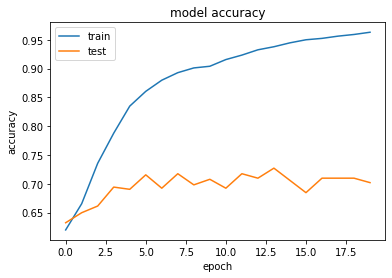

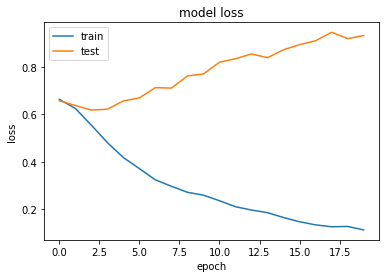

Training Accuracy: 0.9734
Testing Accuracy:  0.7021


In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# Conclusion
On constate donc que ce modèle n'a pas de bon résultat. Il surajute beaucoup trop. Cette solution est donc à abandonner. Pour plus de détail merci de consulter le rapport.